In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import src.support_functions as sf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_auc_score, roc_curve)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer


import joblib

In [2]:
data = data = pd.read_csv('../data/CHURN_FEATURES.csv')

data = data.drop(columns=[
    'ID_VENDEDOR',
    'ID_CAMPANA',
    'ID_VENDEDOR.1',
    'ID_CAMPANA.1',
    'ID_VENDEDOR.2',
    'ID_CAMPANA.2',
    'ID_UBICACION',
    'ID_VENDEDOR.3',
    'ID_CAMPANA.3',
    'ID_VENDEDOR.4',
    'ID_CAMPANA.4',
    'ID_VENDEDOR.5',
    'ID_CAMPANA.5',
    'NUMERO_CAMPANA',
    'NUMERO_CAMPANA.1',
    'PROVINCIA',
    'DISTRITO',
    'ANIO'
])

data.drop(columns=['EDAD_VENDEDORA'], inplace=True, axis=1)
data['ANTIGUEDAD_MESES'] = data['ANTIGUEDAD_MESES'].clip(lower=0)
data.dropna(inplace=True)

In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC


num_features = [
    'ANTIGUEDAD_MESES',
    'MONTO_ACTUAL',
    'MONTO_ANTERIOR',
    'NUM_CAMPANAS_HISTORICAS',
    'CAMPANAS_CONSECUTIVAS_PREVIAS'
]
bin_features = [
    'SEXO',           # map {'F': 0, 'M': 1}
    'TIPO_VENDEDOR',  # map {'Asesora': 0, 'Líder': 1}
    'ES_NUEVA',
    'ES_INICIO_ANIO',
    'ES_NAVIDAD'
]

cat_features = ['DEPARTAMENTO']

def map_binarias(X):
    X = X.copy()
    X['SEXO'] = X['SEXO'].map({'F': 0, 'M': 1}).fillna(0)
    X['TIPO_VENDEDOR'] = X['TIPO_VENDEDOR'].map({'Asesora': 0, 'Líder': 1})
    return X

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('bin', 'passthrough', bin_features) 
])

SVCpipeline = Pipeline([
    ('mapper', FunctionTransformer(map_binarias, validate=False)),
    ('preprocessing', preprocessor),
    ('svc', SVC(C=0.1, gamma=0.01, kernel='rbf', probability=True))
])


In [5]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='TARGET_CHURN')
y = data['TARGET_CHURN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SVCpipeline.fit(X_train, y_train)

y_pred = SVCpipeline.predict(X_test)


In [6]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 698  844]
 [ 249 1621]]
              precision    recall  f1-score   support

           0       0.74      0.45      0.56      1542
           1       0.66      0.87      0.75      1870

    accuracy                           0.68      3412
   macro avg       0.70      0.66      0.65      3412
weighted avg       0.69      0.68      0.66      3412



In [7]:
val_features = pd.read_csv('../data/VALIDATION_FEATURES.csv')
X_val = val_features.drop(columns='TARGET_CHURN')
y_val = val_features['TARGET_CHURN']
y_proba = SVCpipeline.predict_proba(X_val)[:, 1]  
y_pred = SVCpipeline.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[ 59  63]
 [ 16 102]]
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       122
           1       0.62      0.86      0.72       118

    accuracy                           0.67       240
   macro avg       0.70      0.67      0.66       240
weighted avg       0.70      0.67      0.66       240



In [8]:
val_features = pd.read_csv('../data/VALIDATION_FEATURES2.csv')
X_val = val_features.drop(columns='TARGET_CHURN')
y_val = val_features['TARGET_CHURN']
y_proba = SVCpipeline.predict_proba(X_val)[:, 1]  
y_pred = SVCpipeline.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
resultados = val_features.copy()
resultados['PREDICTED_CHURN'] = y_pred
resultados['CHURN_PROB'] = y_proba
resultados.to_excel('../reports/resultados_validacion2.xlsx', index=False)


[[47 30]
 [26 95]]
              precision    recall  f1-score   support

           0       0.64      0.61      0.63        77
           1       0.76      0.79      0.77       121

    accuracy                           0.72       198
   macro avg       0.70      0.70      0.70       198
weighted avg       0.71      0.72      0.72       198



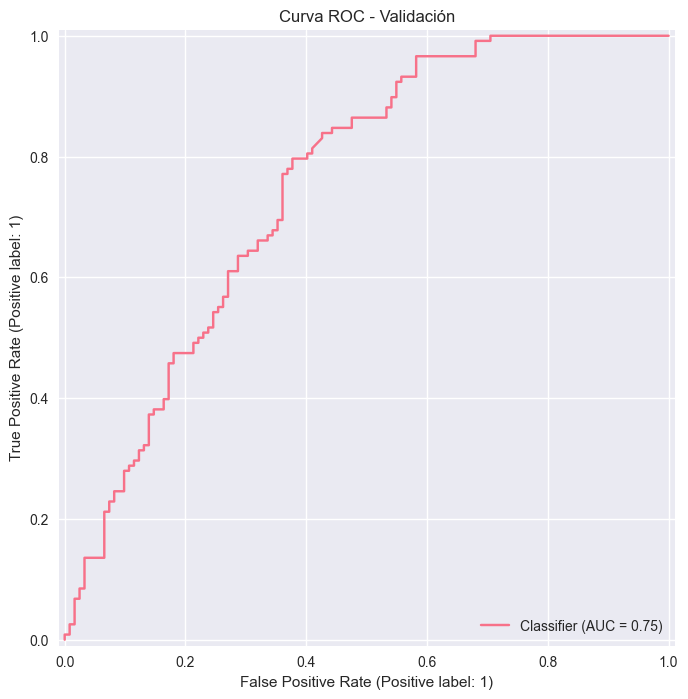

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_val, y_proba)
plt.title("Curva ROC - Validación")
plt.show()

In [32]:
resultados = val_features.copy()
resultados['PREDICTED_CHURN'] = y_pred
resultados['CHURN_PROB'] = y_proba
resultados.to_excel('../reports/resultados_validacion.xlsx', index=False)


In [28]:
resultados = pd.read_csv('resultados_validacion.csv')
resultados.head(
)

,ID_VENDEDOR,ID_CAMPANA,NUMERO_CAMPANA,ANIO,MES,ES_INICIO_ANIO,ES_NAVIDAD,TARGET_CHURN,ID_VENDEDOR.1,ID_CAMPANA.1,...,MONTO_ACTUAL,MONTO_ANTERIOR,ID_VENDEDOR.4,ID_CAMPANA.4,NUM_CAMPANAS_HISTORICAS,ID_VENDEDOR.5,ID_CAMPANA.5,CAMPANAS_CONSECUTIVAS_PREVIAS,PREDICTED_CHURN,CHURN_PROB
0,19742284,25103,131,2025,3,0,0,1,19742284,25103,...,223.96,0.00,19742284,25103,7,19742284,25103,0,1,0.688666
1,19742599,25103,131,2025,3,0,0,0,19742599,25103,...,511.92,201.96,19742599,25103,7,19742599,25103,6,0,0.173061
2,19722710,25103,131,2025,3,0,0,0,19722710,25103,...,1258.82,979.86,19722710,25103,43,19722710,25103,7,0,0.052761
3,19735234,25103,131,2025,3,0,0,0,19735234,25103,...,549.91,0.00,19735234,25103,8,19735234,25103,0,1,0.679928
4,19742906,25103,131,2025,3,0,0,1,19742906,25103,...,329.95,0.00,19742906,25103,1,19742906,25103,0,1,0.687423
